In [1]:
import drdf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def load_drdf(fname):
  reader = drdf.DRDF()
  reader.read(fname)
  events = []
  for run in reader.runs:
    for event in reader.runs[run]:
      hits_map = dict()
      for cam, img in reader.runs[run][event].items():
        amplitude = img.pixels[:, :, 0] 
        time = img.pixels[:, :, 1]
        hits_map[cam] = amplitude
      events.append((event, hits_map))
  return events

In [3]:
#file_drdf_list = ["/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/initial_data_good/response.drdf","/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/new_data/response_pde25.drdf","/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/new_data2/response.drdf","/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/new_data3/response.drdf"]
#file_root_list = ["/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/initial_data_good/sensors.root","/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/new_data/sensors_pde25.root","/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/new_data2/sensors.root","/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/new_data3/sensors.root"]

file_drdf_list = ["/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/good_data_last1/response.drdf", "/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/good_data_last2/response.drdf"]
file_root_list = ["/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/good_data_last1/sensors.root", "/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/good_data_last2/sensors.root"]

In [4]:
def CamList(fname):
    cam_list = []
    file = load_drdf(fname)
    for cam in file[0][1]:
        cam_list.append(cam)
    return cam_list

In [5]:
#creo una matrice 1000 righe x 54 colonne. ogni elemento è una camera 31x31
def AllImages(fname): 
    all_images_list = []
    cam_list = CamList(fname)
    file = load_drdf(fname)
    for i in range(len(file)):
        ph_matrix = []
        for cam in cam_list:
            ph_matrix.append(file[i][1][cam])
        all_images_list.append(ph_matrix)
    all_images = np.array(all_images_list)
    return all_images

In [6]:
def DimensionsData(fname):
    all_images = AllImages(fname)
    cam_list = CamList(fname)
    nr_events = len(all_images)
    nr_pixels = len(all_images[0][0])
    nr_cams = len(cam_list)
    nr_tot_events = nr_cams*nr_events
    nr_pixels_1_ev = nr_pixels*nr_pixels*nr_cams
    return nr_events, nr_pixels, nr_cams, nr_tot_events, nr_pixels_1_ev

In [7]:
#creo una matrice di 1000 righe e 51894 colonne. Così per ogni evento, la riga corrispondente presenta tutti i pixel di tutte le camere
def PixelsAllCamsPerEvents(fname):
    all_images = AllImages(fname)
    nr_events, nr_pixels, nr_cams, nr_tot_events, nr_pixels_1_ev = DimensionsData(fname)
    pixels_to_scale = []
    for images_all_cams_per_ev in all_images: 
        pixels_all_cams_per_ev = images_all_cams_per_ev.flatten()
        pixels_to_scale.append(pixels_all_cams_per_ev)
    pixels_to_scale = np.asarray(pixels_to_scale)
    pixels_to_scale_matrix = pixels_to_scale.reshape(nr_events,nr_pixels_1_ev,1)
    return pixels_to_scale_matrix

In [8]:
def PlotCamsImages(fname):
    all_images = AllImages(fname)
    file = load_drdf(fname)
    cam_list = CamList(fname)
    for i in range(len(all_images)):
        #for cam in cam_list:
        for j in range(len(all_images[i])):
            plt.imshow(all_images[i][j], interpolation='none')
            plt.colorbar()
            plt.title(f"event {file[i][0]} on {cam_list[j]}")
            plt.show()

SCALING DATA

In [9]:
from sklearn.preprocessing import RobustScaler

#applico lo scaling su vettori colonne che sono le camere 31x31 appiattite
def ScalingData(fname):
    pixels_to_scale_matrix = PixelsAllCamsPerEvents(fname)
    nr_events, nr_pixels, nr_cams, nr_tot_events, nr_pixels_1_ev = DimensionsData(fname)
    photons_scaled_all_ev = []
    for pixels in pixels_to_scale_matrix:
        transformer = RobustScaler().fit(pixels)
        photons_scaled_in_cam = transformer.transform(pixels)
        photons_scaled_all_ev.append(photons_scaled_in_cam)
    photons_scaled_all_ev_matrix = np.asarray(photons_scaled_all_ev)
    all_images_scaled = photons_scaled_all_ev_matrix.reshape(nr_events,nr_cams,nr_pixels,nr_pixels)
    return all_images_scaled

In [10]:
#ora ho una matrice 1000righex54colonne dove un elemento è una matrice 31x31. Per essere consistente con i dati di root la voglio trasformare in un array di 54000 elementi
def Flattening(fname):
    all_images_scaled = ScalingData(fname)
    all_images_scaled_1d = []
    for sublist in all_images_scaled:
        all_images_scaled_1d.extend(sublist)
    return all_images_scaled_1d

In [11]:
def Reshaping(fname):
    all_images_scaled_1d_reshaped = []
    all_images = AllImages(fname)
    all_images_scaled_1d = Flattening(fname)
    nr_events, nr_pixels, nr_cams, nr_tot_events, nr_pixels_1_ev = DimensionsData(fname)
    for data in all_images_scaled_1d:
        data_new = data.reshape(nr_pixels,nr_pixels,1)
        all_images_scaled_1d_reshaped.append(data_new)
    return all_images_scaled_1d_reshaped

In [12]:
def PlotCamsImages(fname):
    all_images_scaled = ScalingData(fname)
    file = load_drdf(fname)
    cam_list = CamList(fname)
    for i in range(len(all_images_scaled)):
        for j in range(len(all_images_scaled[i])):
            plt.imshow(all_images_scaled[i][j], interpolation='none')
            plt.colorbar()
            plt.title(f"event {file[i][0]} on {cam_list[j]}")
            plt.show()
            break
        break

In [13]:
def PreprocessWithScaling(fname):
    return Reshaping(fname)

In [14]:
def PreprocessNotScaled(fname):
    matrix = AllImages(fname)
    nr_events, nr_pixels, nr_cams, nr_tot_events, nr_pixels_1_ev = DimensionsData(fname)
    array = matrix.reshape(nr_events*nr_cams, nr_pixels, nr_pixels)
    return array

In [15]:
def SumPhotons(fname):
    tot_photons = []
    all_images = PreprocessNotScaled(fname)
    for j in all_images:
        sum_ph = np.sum(j)
        tot_photons.append(sum_ph)
    return tot_photons

ROOT

In [16]:
import ROOT as root

def OpenRootFile(rname,fname):
    #sensor1.root è il file; ogni camera è un TTree
    input_file = root.TFile.Open(rname, "READ")
    #tree = input_file.Get("CAM_NB_X2")

    cam_list = CamList(fname)

    nr_photons_list_all_cams_list = []
    for cam in cam_list:
        nr_photons_list = []
        tree = input_file.Get(cam)
        entries = tree.GetEntries()
        for i in range(entries):
            n = tree.GetEntry(i)
            inner_photons = tree.innerPhotons
            nr_photons_list.append(inner_photons)
        nr_photons_list_all_cams_list.append(nr_photons_list)
        nr_photons_list_all_cams = np.array(nr_photons_list_all_cams_list)#ho creato una matrice 1000 colonne (nr eventi) x 54 righe (nr camere). I numeri che vediamo sono i numeri di fotoni che arrivano alla camera
    return nr_photons_list_all_cams

Welcome to JupyROOT 6.28/04


In [17]:
nr_photons_list_all_cams = OpenRootFile(file_root_list[0],file_drdf_list[0])

In [18]:
nr_photons_list_all_cams_tr = nr_photons_list_all_cams.transpose()
nr_photons_list_all_cams_tr.shape

(1000, 60)

In [19]:
def EventListNumber(fname):
    file = load_drdf(fname)
    ev_list = []
    for i in range(len(file)):
        ev_list.append(file[i][0])
    return ev_list

In [20]:
def column(matrix, i):
    column = [row[i] for row in matrix]
    return column

def RootDataDictionary(rname,fname):
    nr_photons_list_all_cams = OpenRootFile(rname,fname)
    ev_list = EventListNumber(fname)
    all_photons_in_ev = []
    for i in ev_list:
        nr_photons_in_ev = column(nr_photons_list_all_cams, i)#lista di fotoni in un determinato evento/sono le colonne delle matrici
        all_photons_in_ev.append(nr_photons_in_ev)#faccio una lista di queste liste di fotoni

    cam_list = CamList(fname)

    final_root_data = []
    for i in range(len(all_photons_in_ev)):
        nr_photon_in_cam = []
        for j in range(len(all_photons_in_ev[i])):
            nr_photon_in_cam.append(all_photons_in_ev[i][j])
        dict_cam_ev = dict(zip(cam_list, nr_photon_in_cam))
        final_root_data.append((ev_list[i], dict_cam_ev))
    return final_root_data

In [21]:
root_data = RootDataDictionary(file_root_list[0], file_drdf_list[0])

In [22]:
def InitializeDatasetParameters():
    ratio_thr = 0.1
    sum_thr = 40
    perc_val = 0.2
    perc_train = 0.9
    return ratio_thr, sum_thr, perc_val, perc_train

ratio_thr, sum_thr, perc_val, perc_train = InitializeDatasetParameters()

In [23]:
def InnerPhotonsList(rname,fname):
    final_root_data = RootDataDictionary(rname, fname)
    inner_photons_list = []
    for i in range(len(final_root_data)):
        for cam in final_root_data[i][1].keys():
            inner_photons_list.append(final_root_data[i][1][cam])  
    inner_photons_list = np.asarray(inner_photons_list)
    return inner_photons_list

def CamStatesRootList(rname,fname):
    inner_photons_list = InnerPhotonsList(rname,fname)
    tot_photons = SumPhotons(fname)
    
    ev_cam_state = []
    for i in range(len(inner_photons_list)):
        np.seterr(divide='ignore', invalid='ignore')
        ratio = inner_photons_list[i]/tot_photons[i]
        if ratio >= ratio_thr:
            value = 0
        elif ratio < ratio_thr:
            value = 1
        ev_cam_state.append(value)
    return ev_cam_state

In [24]:
def RootPreprocessing(rname, fname):
    return CamStatesRootList(rname, fname)

In [25]:
def PlotCamsImages(rname, fname):
    all_images = AllImages(fname)
    file = load_drdf(fname)
    cam_list = CamList(fname)
    inner_ph = RootDataDictionary(rname,fname)
    for i in range(len(all_images)):
        #for cam in cam_list:
        for j in range(len(all_images[i])):
            print(inner_ph[j])
            plt.imshow(all_images[i][j], interpolation='none')
            plt.colorbar()
            plt.title(f"event {file[i][0]} on {cam_list[j]}")
            plt.show()

CNN MODEL

In [26]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn import metrics


In [27]:
def Cut(rname: list, fname: list):
    all_images = np.concatenate([PreprocessNotScaled(i) for i in fname]) 
    root_images = np.concatenate([RootPreprocessing(rname[i],fname[i]) for i in range(len(fname))]) 

    index_to_cut = []
    i = 0
    for image in all_images:
        if np.sum(image)<sum_thr:
            index_to_cut.append(i)
        i += 1
    return index_to_cut, all_images, root_images#, all_images_scaled

In [28]:
def DatasetCut(rname: list, fname: list):
    index_to_cut, all_images, root_images = Cut(rname, fname)
    all_images_list = list(all_images)
    root_images_list = list(root_images)
    #all_images_scaled_list = list(all_images_scaled)
    
    for i in sorted(index_to_cut, reverse=True):
        del all_images_list[i], root_images_list[i]#, all_images_scaled_list[i]

    data_cut = np.array(all_images_list)
    root_cut = np.array(root_images_list)
    #data_scaled_cut = np.array(all_images_scaled_list)

    data_cut = data_cut.reshape(data_cut.shape[0],32,32,1)
    #data_scaled_cut = data_scaled_cut.reshape(data_scaled_cut.shape[0],32,32,1)

    return data_cut, root_cut#, data_scaled_cut

In [29]:
data_cut, root_cut = DatasetCut(file_root_list, file_drdf_list)

In [57]:
def PrepareData(rname: list, fname: list):
    data_cut, root_cut = DatasetCut(rname, fname)
    t_ds, val_ds, t_labels, val_labels = train_test_split(data_cut, root_cut, train_size=0.9, random_state=42)
    train_ds, test_ds, train_labels, test_labels = train_test_split(t_ds, t_labels, train_size=0.9, random_state=42)

    train_ds = np.asarray(train_ds)
    val_ds = np.asarray(val_ds)
    test_ds = np.asarray(test_ds)

    train_ds = train_ds.reshape(train_ds.shape[0], 32, 32,1)
    val_ds = val_ds.reshape(val_ds.shape[0], 32, 32, 1)
    test_ds = test_ds.reshape(test_ds.shape[0],32,32,1)

    return train_ds, val_ds, test_ds, train_labels, val_labels, test_labels

In [58]:
def FindBlindEvents(rarray,farray):
    # ev_cam_state = RootPreprocessing(rname,fname)
    # data_prep = PreprocessWithScaling(fname)
    n = 0
    nr_blind_events = []
    blind_events = []
    for i in rarray:
        if i == 0:
            nr_blind_events.append(n)
        n+=1
    for i in nr_blind_events:
        blind_events.append(farray[i])
    return nr_blind_events, blind_events

In [59]:
def Augmentation(rarray, farray):
    input_shape = [32,32,32,1]
    data_augmentation = keras.Sequential()
    data_augmentation.add(layers.RandomFlip("horizontal", input_shape=input_shape[1:]))
    data_augmentation.add(layers.RandomRotation(0.2))
    #data_augmentation.add(layers.RandomTranslation(0.2,0.2))
    data_augmentation.add(layers.RandomZoom(0.8))
    
    nr_blind_events1, blind_events1 = FindBlindEvents(rarray,farray)
    # nr_blind_events2, blind_events2 = FindBlindEvents(rname[1], fname[1])
    # nr_blind_events3, blind_events3 = FindBlindEvents(rname[2], fname[2])
    # nr_blind_events14, blind_events4 = FindBlindEvents(rname[3], fname[3])
    
    #all_blind_events = np.concatenate((blind_events1), axis=0)#,blind_events2,blind_events3,blind_events4), axis=0)

    augmented_ds = []
    for blind_im in blind_events1:
        for i in range(150):
            augmented_image = data_augmentation(blind_im)
            augmented_image_sq = np.squeeze(augmented_image, axis=3)
            augmented_ds.append(augmented_image_sq)
    augmented_ds = np.asarray(augmented_ds)

    augmented_labels = len(augmented_ds)*[0]
    return augmented_ds, augmented_labels

In [60]:
def DatasetwithAugmentation(rname: list, fname: list, rarray, farray):
    train_ds, val_ds, test_ds,train_labels, val_labels,test_labels = PrepareData(rname, fname)
    augmented_ds, augmented_labels = Augmentation(rarray, farray)
    train_ds_aug = np.concatenate((train_ds,augmented_ds),axis=0)
    train_labels_aug = np.concatenate((train_labels,augmented_labels),axis=0)
    return train_ds_aug, train_labels_aug

In [61]:
def DatasetWeights(rarray, farray):
    nr_blind_events1, blind_events1 = FindBlindEvents(rarray, farray)

    augmented_ds, augmented_labels = Augmentation(rarray, farray)
    
    nr_blind_ev = len(nr_blind_events1) + len(augmented_ds) #+ len(nr_blind_events4) + len(nr_blind_events2) + len(nr_blind_events3)
    nr_tot_ev = len(rarray) + len(augmented_ds)#nr_tot_events1 + nr_tot_events2 + nr_tot_events3 + nr_tot_events4 + len(augmented_ds) - len(root_to)
    nr_not_blind_ev = nr_tot_ev - nr_blind_ev

    initial_bias = np.log(nr_blind_ev/nr_not_blind_ev)

    weights_0 = (1/nr_blind_ev)*(nr_tot_ev/2)
    weights_1 = (1/nr_not_blind_ev)*(nr_tot_ev/2)
    weights_classes = {0: weights_0, 1: weights_1}

    percentage = {0: nr_blind_ev/nr_tot_ev, 1: nr_not_blind_ev/nr_tot_ev}

    return initial_bias, weights_classes, percentage

In [62]:
train_ds, val_ds, test_ds,train_labels, val_labels,test_labels = PrepareData(file_root_list, file_drdf_list)

In [63]:
train_ds_aug, train_labels_aug = DatasetwithAugmentation(file_root_list, file_drdf_list, root_cut, data_cut)

In [64]:
initial_bias, weights_classes, percentage = DatasetWeights(root_cut, data_cut)

In [65]:
percentage

{0: 0.3492838169316608, 1: 0.6507161830683392}

In [66]:
weights_classes

{0: 1.4315006185867114, 1: 0.7683841481278931}

In [67]:
#PARAMETERS for NN
def InitializeCNNParameters():
    batch_size = 32
    epochs = 10
    input_shape = [batch_size, 32,32,1]
    metric = keras.metrics.F1Score()
    loss_func = tf.keras.losses.BinaryCrossentropy()
    return batch_size, epochs, input_shape,metric,loss_func

In [68]:
batch_size, epochs, input_shape, metric,loss_func = InitializeCNNParameters()

In [69]:
def Training(rname: list, fname: list): 
    #initial_bias, weights_classes = DatasetWeights(rname,fname)
    #input_shape = [32,32,32,1]
    output_bias = keras.initializers.Constant(initial_bias)

    model = models.Sequential([
    # Flatten layer per trasformare l'immagine in un vettore
    layers.Conv2D(32, (3,3), activation='relu',input_shape = input_shape[1:]),
    layers.MaxPooling2D((2,2)),
    #layers.Dropout(0.2),
    layers.Conv2D(64, (3,3), activation='relu'),#input_shape = input_shape[1:]),
    layers.MaxPooling2D((2,2)),
    # layers.Dropout(0.2),
    # layers.Conv2D(32, (3,3), activation='relu'),#input_shape = input_shape[1:]),
    # layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),
    layers.Flatten(),#(input_shape = input_shape[1:]),
    
    # Dense layers per la parte completamente connessa della rete
    layers.Dense(128, activation='relu', bias_initializer=output_bias),
    layers.Dense(64, activation='relu'),
    layers.Dense(32,activation='relu'),
    
    # Output layer con un neurone e attivazione sigmoide per classificazione binaria
    layers.Dense(1, activation='sigmoid')
])

    model.compile(optimizer='adam', loss=loss_func, metrics=metric)#, run_eagerly=True)#,'precision','recall'])
    model.summary()
    return model


In [70]:
model = Training(file_root_list, file_drdf_list)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 64)          0         
                                                                 
 flatten_1 (Flatten)         (None, 2304)             

In [71]:
#callbacks = [keras.callbacks.ModelCheckpoint("/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/ultima_versione_buoni/tf_model_new/cams_model_new.keras")]
train_labels_aug = train_labels_aug.astype(np.float32)
val_labels = val_labels.astype(np.float32)
history = model.fit(train_ds_aug, train_labels_aug, validation_data= (val_ds, val_labels), epochs=epochs, batch_size=batch_size, class_weight=weights_classes)

Epoch 1/10
4308/4308 [==============================] - 48s 11ms/step - loss: 0.0411 - f1_score: 0.8737 - val_loss: 0.0122 - val_f1_score: 0.9991
Epoch 2/10
4308/4308 [==============================] - 47s 11ms/step - loss: 0.0157 - f1_score: 0.9316 - val_loss: 0.0158 - val_f1_score: 0.9991
Epoch 3/10
4308/4308 [==============================] - 47s 11ms/step - loss: 0.0138 - f1_score: 0.9323 - val_loss: 0.0135 - val_f1_score: 0.9990
Epoch 4/10
4308/4308 [==============================] - 47s 11ms/step - loss: 0.0134 - f1_score: 0.8992 - val_loss: 0.0106 - val_f1_score: 0.9991
Epoch 5/10
4308/4308 [==============================] - 47s 11ms/step - loss: 0.0120 - f1_score: 0.9131 - val_loss: 0.0097 - val_f1_score: 0.9991
Epoch 6/10
4308/4308 [==============================] - 49s 11ms/step - loss: 0.0164 - f1_score: 0.9372 - val_loss: 0.0123 - val_f1_score: 0.9992
Epoch 7/10
4308/4308 [==============================] - 51s 12ms/step - loss: 0.0111 - f1_score: 0.9411 - val_loss: 0.0111 -

In [72]:
saved_model = model.save("/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/ultima_versione_buoni/tf_model_new/cams_model_aug2_last.keras")

In [73]:
predictions_val = model.predict(val_ds)
predictions = np.squeeze(predictions_val)

i = 0
predictions_val_approx = []
for value in predictions:
    value_approx = int(round(value,0))
    predictions_val_approx.append(value_approx)

predictions_val_approx = np.asarray(predictions_val_approx)

322/322 [==============================] - 1s 3ms/step


[[   19    11]
 [    5 10242]]


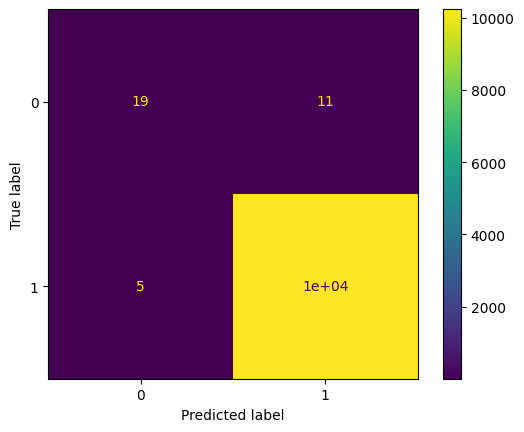

In [74]:
from sklearn import metrics 

cm = metrics.confusion_matrix(val_labels, predictions_val_approx)
print(cm)
cm_display = metrics.ConfusionMatrixDisplay(cm).plot()

In [75]:
test_ds = test_ds.reshape(test_ds.shape[0], 32, 32, 1)
predictions_test = model.predict(test_ds)
predictions = np.squeeze(predictions_test)

i = 0
predictions_test_approx = []
for value in predictions:
    value_approx = int(round(value,0))
    predictions_test_approx.append(value_approx)

predictions_test_approx = np.asarray(predictions_test_approx)

290/290 [==============================] - 1s 3ms/step


[[  24   16]
 [   5 9204]]


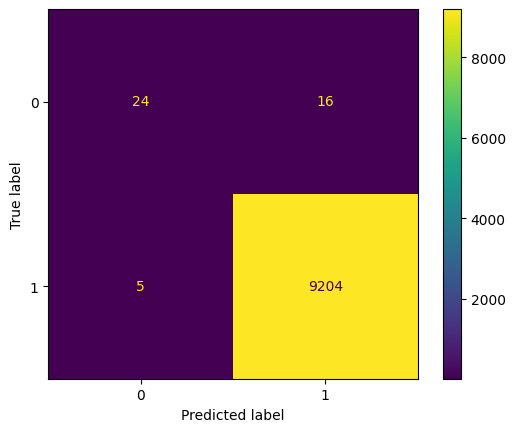

In [76]:
cm_test = metrics.confusion_matrix(test_labels, predictions_test_approx)
print(cm_test)
cm_display = metrics.ConfusionMatrixDisplay(cm_test).plot()

In [77]:
F1 = metrics.f1_score(test_labels, predictions_test_approx, average = 'binary')
F1

0.9988604916164739

In [78]:
tp = []
fp = []
fn = []
tn = []

for i in range(len(test_ds)):
    if test_labels[i] == 1 and predictions_test_approx[i] == 1:
        tp.append(i)

for i in range(len(test_ds)):
    if test_labels[i] == 0 and predictions_test_approx[i] == 1:
        fp.append(i)

for i in range(len(test_ds)):
    if test_labels[i] == 1 and predictions_test_approx[i] == 0:
        fn.append(i)

for i in range(len(test_ds)):
    if test_labels[i] == 0 and predictions_test_approx[i] == 0:
        tn.append(i)

In [87]:
inner_ph = InnerPhotonsList(file_root_list[0],file_drdf_list[0])

In [97]:
for i in tp:
    #if inner_ph[i] != 0:
        print(inner_ph[i])

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
237
6864
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0

In [79]:
test_list = ["/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/good_data_last4/response.drdf"]
labels_list = [ "/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/good_data_last4/sensors.root"]

file3, file3_labels = DatasetCut(labels_list, test_list)

In [80]:
predictions_file = model.predict(file3)
predictions_file = np.squeeze(predictions_file)

1676/1676 [==============================] - 5s 3ms/step


In [81]:
i = 0
predictions_approx = []
for value in predictions_file:
    if value >= 0.5:
        value_approx = 1
    if value < 0.5:
        value_approx = 0
    predictions_approx.append(value_approx)

predictions_approx = np.asarray(predictions_approx)

[[  340   186]
 [   85 53018]]


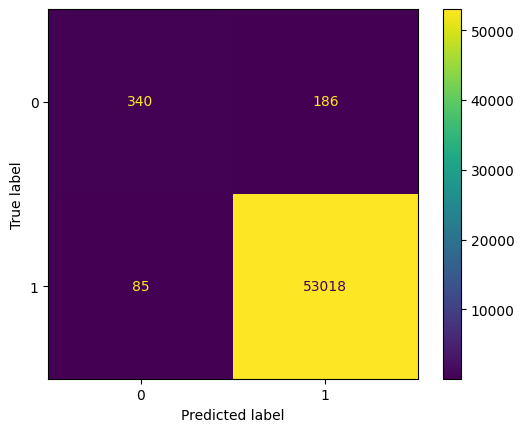

In [82]:
#test_labels ha shape 4860
cm = metrics.confusion_matrix(file3_labels, predictions_approx)
print(cm)
cm_display = metrics.ConfusionMatrixDisplay(cm).plot()

In [84]:
tp_list = []
fp_list = []
fn_list = []
tn_list = []

for i in range(len(file3)):
    if file3_labels[i] == 1 and predictions_approx[i] == 1:
        tp_list.append(i)

for i in range(len(file3)):
    if file3_labels[i] == 0 and predictions_approx[i] == 1:
        fp_list.append(i)

for i in range(len(file3)):
    if file3_labels[i] == 1 and predictions_approx[i] == 0:
        fn_list.append(i)

for i in range(len(file3)):
    if file3_labels[i] == 0 and predictions_approx[i] == 0:
        tn_list.append(i)

In [90]:
inner_ph1 = InnerPhotonsList(labels_list[0],test_list[0])

0


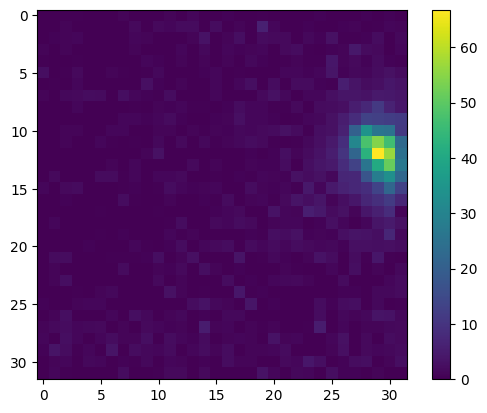

0


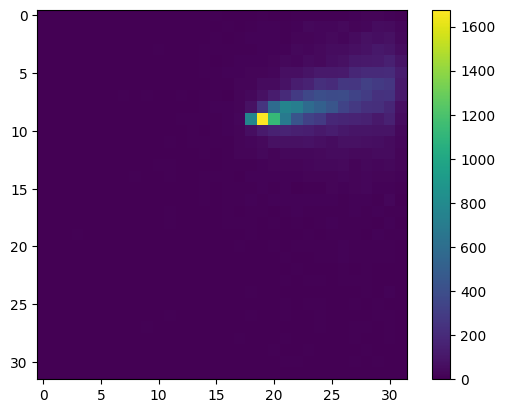

0


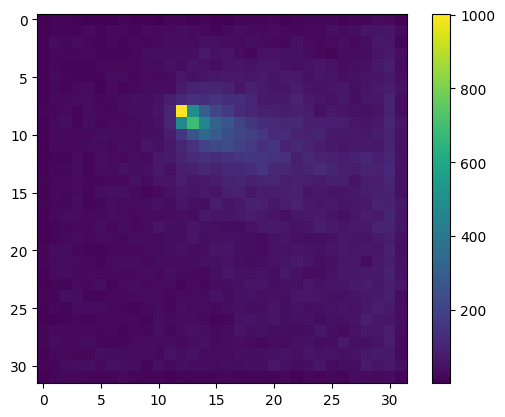

0


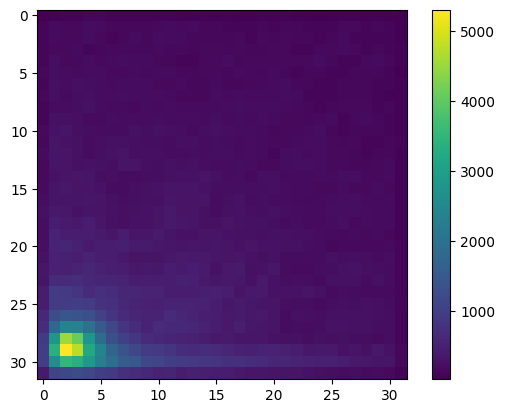

0


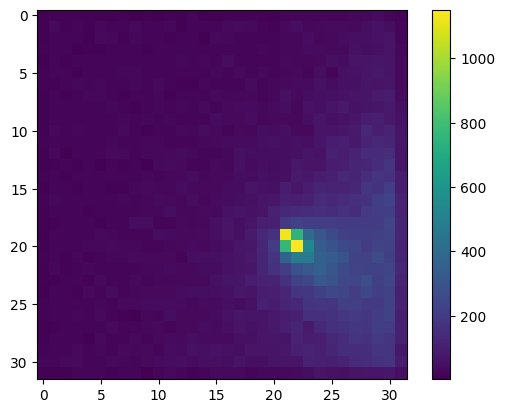

0


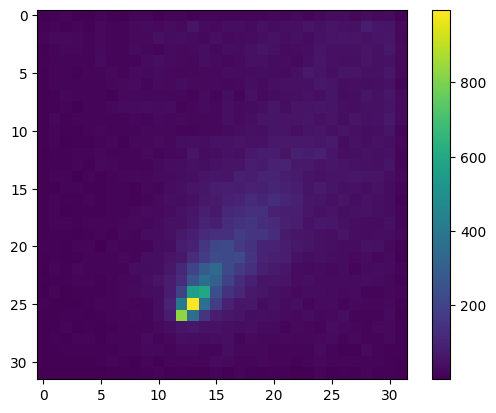

0


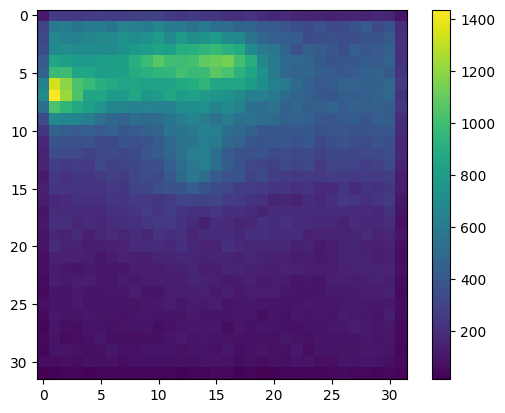

0


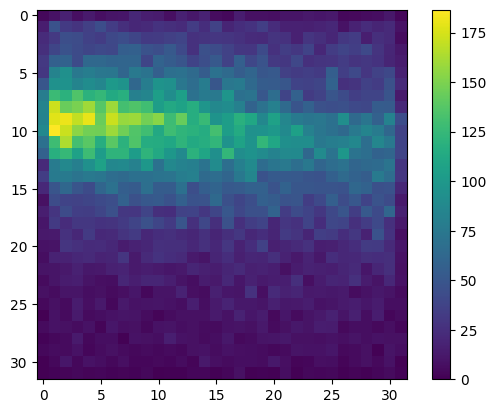

0


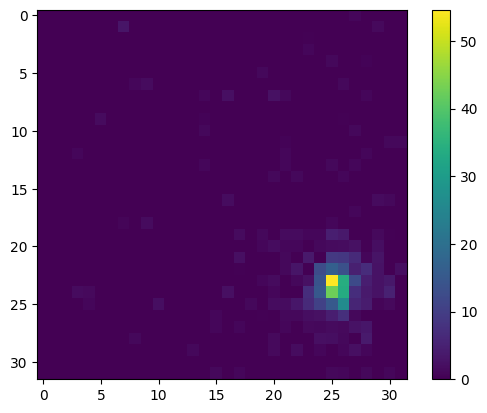

0


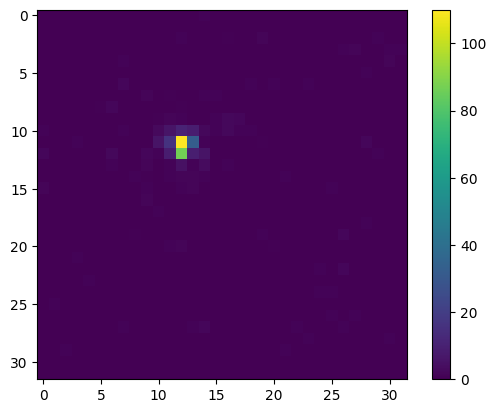

0


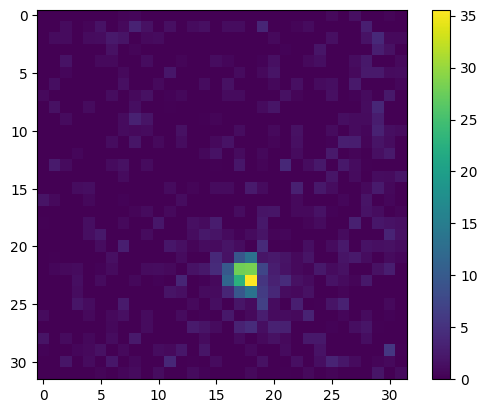

0


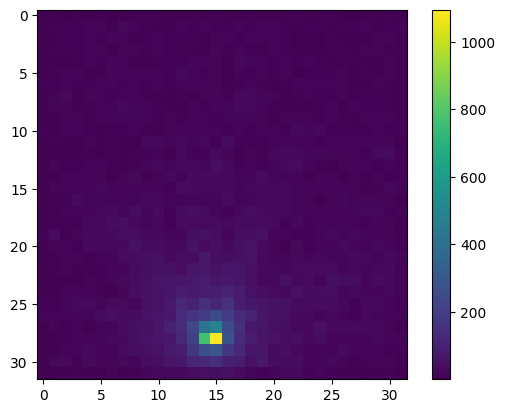

0


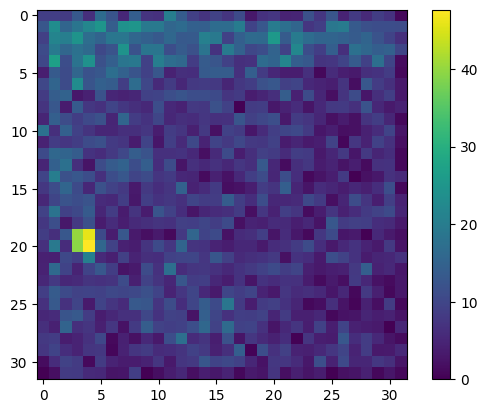

0


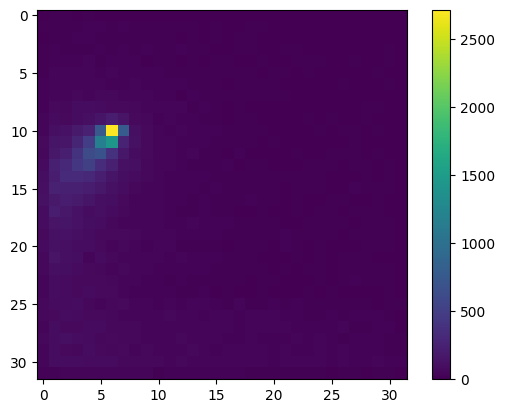

0


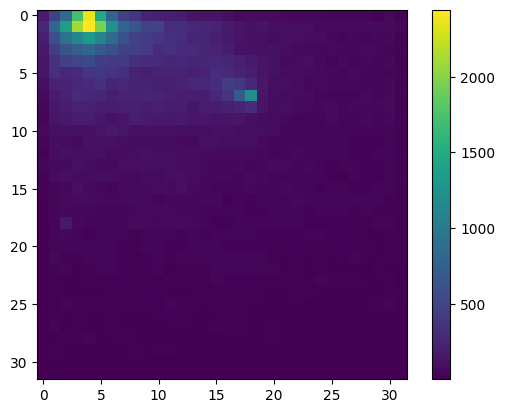

0


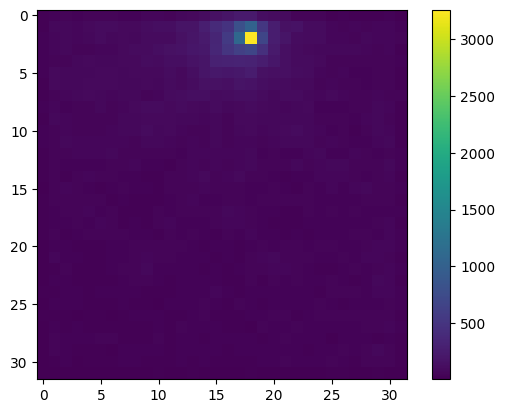

0


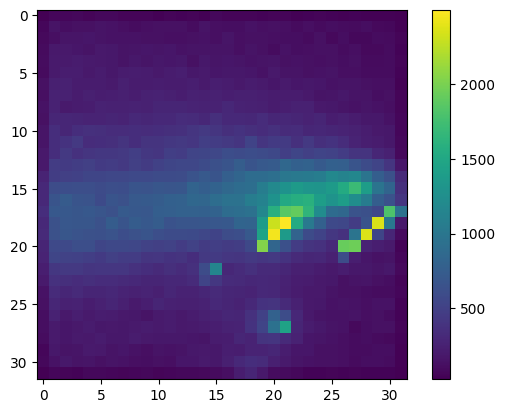

0


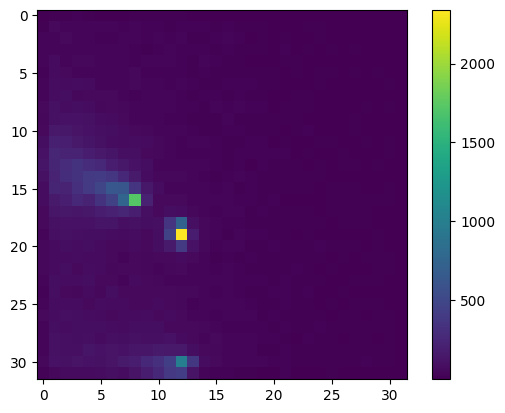

0


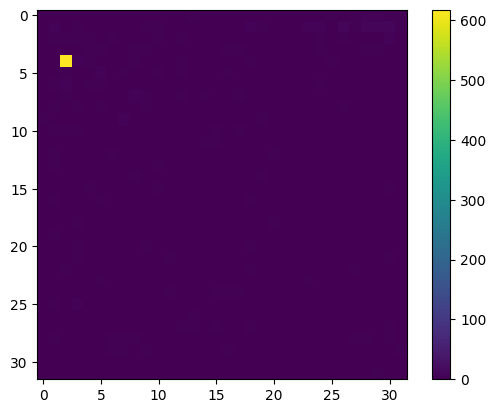

0


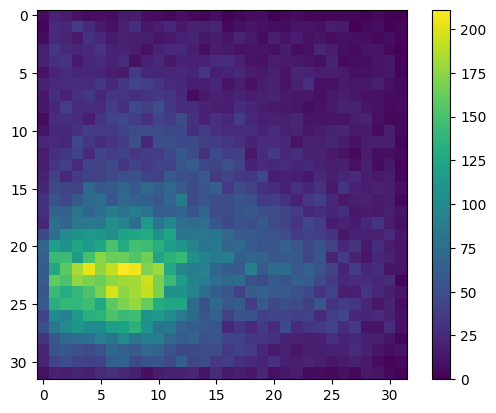

0


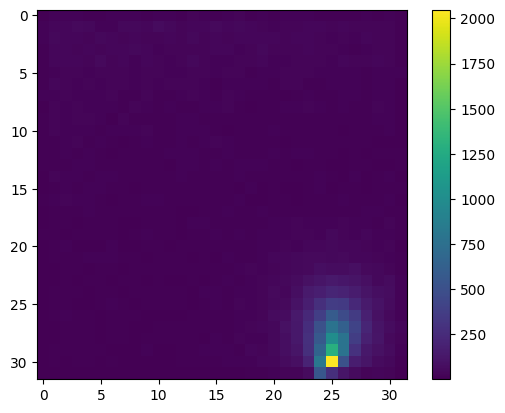

0


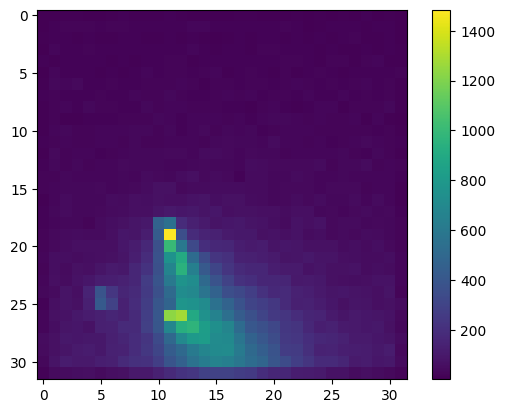

0


KeyboardInterrupt: 

In [91]:
for i in tn_list:
    print(inner_ph1[i])
    plt.imshow(file3[i])
    plt.colorbar()
    plt.show()

In [83]:
import sys

original_stdout = sys.stdout # Save a reference to the original standard output

with open('results.txt', 'a') as f:
    sys.stdout = f # Change the standard output to the file we created.
    model.summary()
    print("ratio_thr, sum_thr, perc_val, perc_train: ", InitializeDatasetParameters())
    print("batch_size, epochs, input_shape, metric,loss_func: ", InitializeCNNParameters())
    print(cm_test)
    print(cm)
    sys.stdout = original_stdout # Reset the standard output to its original value